In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/paysim.csv")
df = df[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()

print("Shape:", df.shape)
print("Fraud rate:", df["isFraud"].mean(), f"({df['isFraud'].mean()*100:.4f}%)")


Shape: (2770409, 11)
Fraud rate: 0.002964544224336551 (0.2965%)


In [2]:
# sortieren nach Zeit (step)
df = df.sort_values("step").reset_index(drop=True)

split_step = int(df["step"].quantile(0.8))  # ca. 80% der Zeit als Train
train = df[df["step"] <= split_step].copy()
test  = df[df["step"] >  split_step].copy()

print("Split step:", split_step)
print("Train:", train.shape, "Fraud rate:", train["isFraud"].mean())
print("Test :", test.shape,  "Fraud rate:", test["isFraud"].mean())


Split step: 354
Train: (2217905, 11) Fraud rate: 0.0017832143396583713
Test : (552504, 11) Fraud rate: 0.007706731534975312


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression

target = "isFraud"

feature_cols = [
    "type", "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

X_train = train[feature_cols]
y_train = train[target]
X_test  = test[feature_cols]
y_test  = test[target]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["type"]),
        ("num", "passthrough", ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]),
    ]
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))


ROC-AUC: 0.9820751105467879
PR-AUC : 0.7249550121551954


In [4]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = [0.5, 0.3, 0.2, 0.1, 0.05]
rows = []

for t in thresholds:
    pred = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
    rows.append((t, p, r, f1, pred.sum()))

result = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","alerts_predicted"])
result


,threshold,precision,recall,f1,alerts_predicted
0,0.50,0.113717,0.915688,0.202309,34287
1,0.30,0.050849,0.984265,0.096702,82421
2,0.20,0.033355,0.989197,0.064534,126278
3,0.10,0.022362,0.993189,0.043739,189117
4,0.05,0.017387,0.993894,0.034176,243399


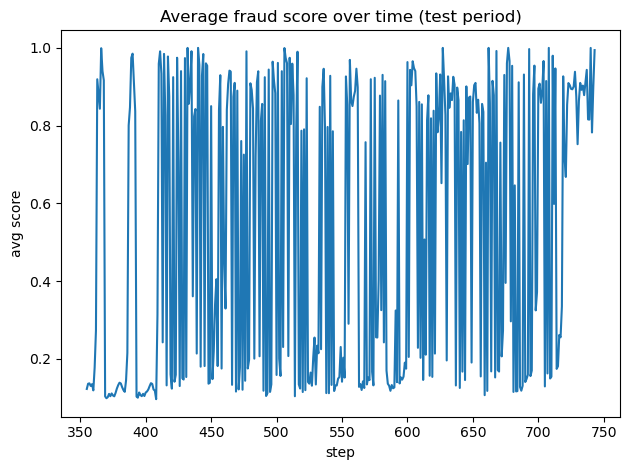

In [6]:
test = test.copy()
test["score"] = proba
score_by_step = test.groupby("step")["score"].mean()

import matplotlib.pyplot as plt
score_by_step.plot()
plt.title("Average fraud score over time (test period)")
plt.ylabel("avg score")
plt.tight_layout()
plt.savefig("../reports/figures/avg_score_over_time_test.png", dpi=150)
plt.show()


In [7]:
result


,threshold,precision,recall,f1,alerts_predicted
0,0.50,0.113717,0.915688,0.202309,34287
1,0.30,0.050849,0.984265,0.096702,82421
2,0.20,0.033355,0.989197,0.064534,126278
3,0.10,0.022362,0.993189,0.043739,189117
4,0.05,0.017387,0.993894,0.034176,243399


In [8]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

thresholds = [0.99, 0.97, 0.95, 0.93, 0.90, 0.85, 0.80]
rows = []

for t in thresholds:
    pred = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
    rows.append((t, p, r, f1, int(pred.sum())))

pd.DataFrame(rows, columns=["threshold","precision","recall","f1","alerts_predicted"])


,threshold,precision,recall,f1,alerts_predicted
0,0.99,0.842862,0.550493,0.666004,2781
1,0.97,0.722359,0.618365,0.666329,3645
2,0.95,0.645853,0.658290,0.652012,4340
3,0.93,0.581714,0.688821,0.630753,5042
4,0.90,0.501306,0.720996,0.591408,6124
5,0.85,0.409497,0.775716,0.536027,8066
6,0.80,0.332600,0.816815,0.472715,10457


In [9]:
q = 0.99  # Top 1% Scores als Alerts
t = float(pd.Series(proba).quantile(q))

pred = (proba >= t).astype(int)

from sklearn.metrics import precision_recall_fscore_support
p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)

print("Chosen threshold from quantile:", t)
print("alerts_predicted:", int(pred.sum()))
print("precision:", p, "recall:", r, "f1:", f1)


Chosen threshold from quantile: 0.9166270749374389
alerts_predicted: 5526
precision: 0.5427072023163229 recall: 0.7043212775951151 f1: 0.6130417007358954


In [11]:
# Operating point: review capacity = top 1% highest-risk transactions
q = 0.99
threshold = float(pd.Series(proba).quantile(q))
pred = (proba >= threshold).astype(int)

from sklearn.metrics import precision_recall_fscore_support
p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)

print("Operating point (top 1%):")
print("threshold:", threshold)
print("alerts_predicted:", int(pred.sum()))
print("precision:", p)
print("recall:", r)
print("f1:", f1)


Operating point (top 1%):
threshold: 0.9166270749374389
alerts_predicted: 5526
precision: 0.5427072023163229
recall: 0.7043212775951151
f1: 0.6130417007358954


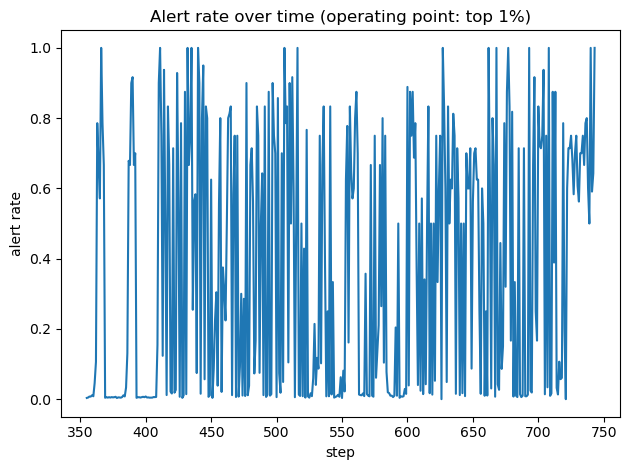

In [12]:
test = test.copy()
test["score"] = proba
test["alert"] = (test["score"] >= threshold).astype(int)

alert_rate_by_step = test.groupby("step")["alert"].mean()

import matplotlib.pyplot as plt
alert_rate_by_step.plot()
plt.title("Alert rate over time (operating point: top 1%)")
plt.ylabel("alert rate")
plt.tight_layout()
plt.savefig("../reports/figures/alert_rate_over_time_top1pct.png", dpi=150)
plt.show()


Key outputs

Time-based split using step (production-like evaluation)

Baseline: Logistic Regression with class weighting

Metrics: ROC-AUC ~ 0.98, PR-AUC ~ 0.72

Operating point: top 1% scores (threshold ~ 0.92)

Precision ~ 0.54, Recall ~ 0.70 at operating point

Monitoring: alert rate over time plot